In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.datasets import imdb
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, SimpleRNN, Bidirectional, Dense
import keras_tuner as kt
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
max_features = 10000  # кількість слів, що розглядаються як особливості
maxlen = 500  # обмеження кількості слів в тексті

In [3]:
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
# Завантаження тренувальних та тестових даних зі вказанням обмеження на кількість слів

In [4]:
x_train = pad_sequences(x_train, maxlen=maxlen)
x_test = pad_sequences(x_test, maxlen=maxlen)
# Застосування заздалегідь обраної максимальної довжини до послідовних даних тренувального та тестового наборів

In [5]:
def build_model(hp):
    model = Sequential()
    model.add(Embedding(max_features, 128, input_length=maxlen))

    layer_choice = hp.Choice('layer', values=['LSTM', 'SimpleRNN'])
    layer_cls = LSTM if layer_choice == 'LSTM' else SimpleRNN
    
    bidirect_choice = hp.Choice('bidirectional', values=[True, False])
    n_layers = hp.Int('num_layers', min_value=1, max_value=3, step=1)
    
    for i in range(n_layers):
        if bidirect_choice:
            forward_layer = layer_cls(units=64, return_sequences=True if n_layers-i > 1 else False)
            backward_layer = layer_cls(units=64, return_sequences=True if n_layers-i > 1 else False, go_backwards=True)
            bidirectional_layer = Bidirectional(forward_layer, backward_layer=backward_layer)
            model.add(bidirectional_layer)
        else:
            model.add(layer_cls(units=64, return_sequences=True if n_layers-i > 1 else False))
    
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [6]:
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    directory='my_dir',
    project_name='imdb'
)

In [8]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=4, restore_best_weights=True)

tuner.search(x_train, y_train, epochs=400, batch_size=128, validation_split=0.3, callbacks=[early_stopping])

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 10 Complete [01h 59m 10s]
val_accuracy: 0.8804000020027161

Best val_accuracy So Far: 0.8804000020027161
Total elapsed time: 14h 23m 07s


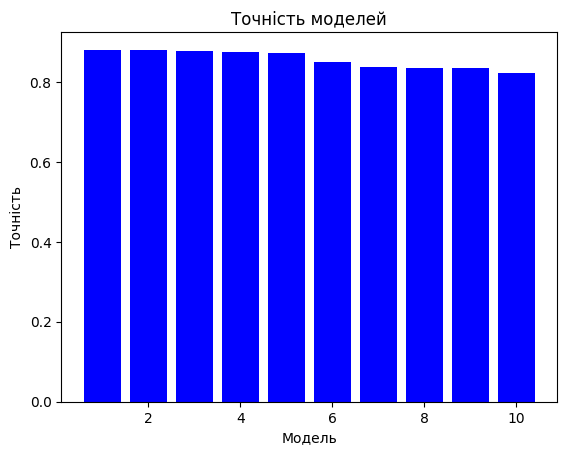


Проба 1:
layer: LSTM
bidirectional: 1
num_layers: 1

Проба 2:
layer: LSTM
bidirectional: 0
num_layers: 2

Проба 3:
layer: LSTM
bidirectional: 0
num_layers: 1

Проба 4:
layer: LSTM
bidirectional: 0
num_layers: 3

Проба 5:
layer: LSTM
bidirectional: 1
num_layers: 2

Проба 6:
layer: SimpleRNN
bidirectional: 0
num_layers: 3

Проба 7:
layer: SimpleRNN
bidirectional: 0
num_layers: 2

Проба 8:
layer: SimpleRNN
bidirectional: 1
num_layers: 2

Проба 9:
layer: SimpleRNN
bidirectional: 0
num_layers: 1

Проба 10:
layer: SimpleRNN
bidirectional: 1
num_layers: 1


In [56]:
tuner_results = tuner.oracle.get_best_trials(num_trials=len(tuner.oracle.trials))

accuracies = [trial.metrics.get_history('val_accuracy')[0].value for trial in tuner_results]
hyperparameters = [trial.hyperparameters.values for trial in tuner_results]

accuracies = [acc[0] for acc in accuracies]

# Побудова стовпчастої діаграми
plt.bar(range(1,len(accuracies)+1), accuracies, color='blue')
plt.title('Точність моделей')
plt.xlabel('Модель')
plt.ylabel('Точність')
plt.show()

for i, params in enumerate(hyperparameters):
    print(f"\nПроба {i + 1}:")
    for param, value in params.items():
        print(f"{param}: {value}")

In [58]:
model = tuner.hypermodel.build(best_hps)

history = model.fit(x_train, y_train, epochs=5, batch_size=128, validation_split=0.3, callbacks=[early_stopping])
# Запускаємо навчання моделі на тренувальних даних для 5 епох з розміром пакету 128 та розбиттям на тренувальну та валідаційну підмножини

Epoch 1/5
137/137 [==============================] - 1444s 10s/step - loss: 0.4596 - accuracy: 0.7746 - val_loss: 0.3272 - val_accuracy: 0.8667
Epoch 2/5
137/137 [==============================] - 1424s 10s/step - loss: 0.2903 - accuracy: 0.8833 - val_loss: 0.3550 - val_accuracy: 0.8472
Epoch 3/5
137/137 [==============================] - 1304s 10s/step - loss: 0.1940 - accuracy: 0.9286 - val_loss: 0.3346 - val_accuracy: 0.8603
Epoch 4/5
137/137 [==============================] - 1293s 9s/step - loss: 0.1478 - accuracy: 0.9486 - val_loss: 0.3415 - val_accuracy: 0.8689
Epoch 5/5
137/137 [==============================] - 1307s 10s/step - loss: 0.1060 - accuracy: 0.9643 - val_loss: 0.3860 - val_accuracy: 0.8695


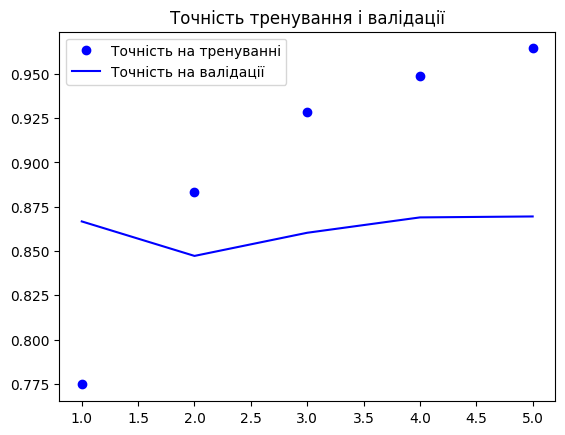

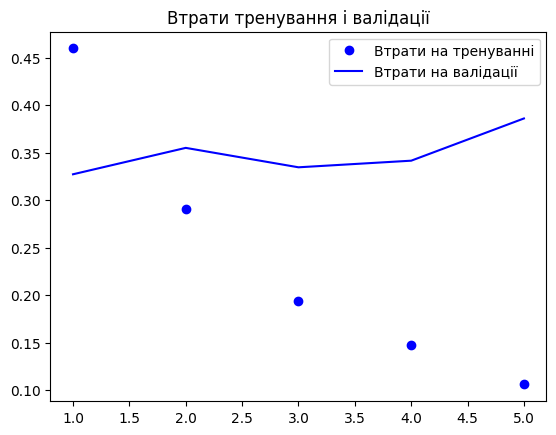

In [59]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Точність на тренуванні')
plt.plot(epochs, val_acc, 'b', label='Точність на валідації')
plt.title('Точність тренування і валідації')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Втрати на тренуванні')
plt.plot(epochs, val_loss, 'b', label='Втрати на валідації')
plt.title('Втрати тренування і валідації')
plt.legend()

plt.show()

In [60]:
# Оцінка моделі на тестових даних
test_loss, test_acc = model.evaluate(x_test, y_test)
print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

782/782 [==============================] - 108s 138ms/step - loss: 0.4132 - accuracy: 0.8602
Test Loss: 0.4131714403629303
Test Accuracy: 0.8602399826049805
